In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
def gaus_kernel(x_n, x_m, theta, grad=False):
    return theta[0] * np.exp(-(theta[1]/2)*(x_n-x_m)**2)+theta[2]+theta[3]*np.dot(x_n,  x_m)

In [3]:
n=100
theta = np.array([1, 2, 0, 0], dtype=np.float)
x = np.linspace(start=0, stop=10, num=n)
color = ['r', 'g', 'b']

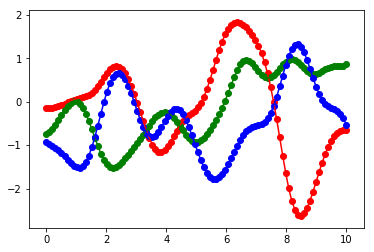

In [4]:
# gaussian process
for c in color:
    cov = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            cov[i,j] = gaus_kernel(x[i], x[j], theta)
    z = np.zeros(n)
    ys = np.random.multivariate_normal(z, cov)  
    plt.plot(x, ys, color=c)
    plt.scatter(x, ys, color=c)

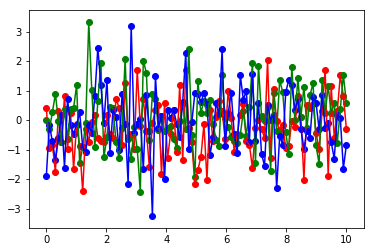

In [5]:
# independent version of gaussian process
for c in color:
    cov = np.eye(n)
    z = np.zeros(n)
    ys = np.random.multivariate_normal(z, cov)  
    plt.plot(x, ys, color=c)
    plt.scatter(x, ys, color=c)

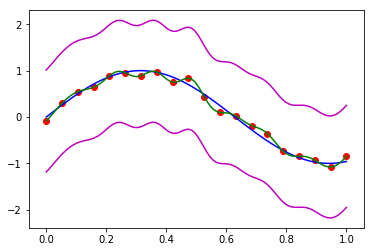

In [6]:
# regression by gaussian process
def target_fn(x):
    return np.sin(5*x)

# true data
x_true = np.linspace(0, 1, 100)
y_true = target_fn(x_true)

# target data
sample_num = 20
x_samples = np.linspace(0, 1, sample_num)
# x_samples = np.random.uniform(size=sample_num)
# x_samples[0]=0; x_samples[-1]=1
t = target_fn(x_samples) + np.random.normal(0.0, 0.1, size=len(x_samples))

# hyper parameter
beta = 10.0
# smaller theta_1 for larger sample_num is better
theta = np.array([1, 200, 0, 0], dtype=np.float)

# compute covariance
def compute_covar(x_samples, theta):
    cov = np.zeros((len(x_samples), len(x_samples)))
    for i, x_i in enumerate(x_samples):
        for j, x_j in enumerate(x_samples):       
            cov[i,j] = gaus_kernel(x_i, x_j, theta)
    return cov
cov = compute_covar(x_samples, theta)
inv_cov = np.linalg.inv(cov)

# predicts data
x_preds = np.linspace(0, 1, 100)
mu = np.zeros_like(x_preds)
var = np.zeros_like(x_preds)
for i, x_pred in enumerate(x_preds):
    k = np.array([gaus_kernel(x_pred, x_sample, theta) for x_sample in x_samples])
    mu[i] = np.dot(np.dot(k, inv_cov),t)
    var[i] = gaus_kernel(x_pred, x_pred, theta) + 1/beta

# make plots
xs = [x_true, x_preds, x_preds, x_preds]
ys = [y_true, mu, mu+var, mu-var]
cs = ['b', 'g', 'm', 'm']
for x, y, c in zip(xs, ys, cs):
    plt.plot(x, y, color=c)
plt.scatter(x_samples, t, color='r')

100%|██████████| 2000/2000 [00:03<00:00, 587.53it/s]


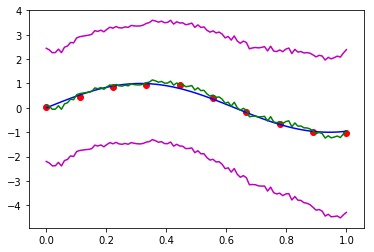

In [66]:
# learn hyperparameter 

# target data
sample_num = 10
x_samples = np.linspace(0, 1, sample_num)
#x_samples = np.random.uniform(size=sample_num)
#x_samples[0]=0; x_samples[-1]=1
t = target_fn(x_samples) + np.random.normal(0.0, 0.1, size=len(x_samples))

# hyper parameter
lr = 1e-38# learning rate
beta = 10.0 
theta = np.ones(4, dtype=np.float)

def compute_c_theta1(x_samples, theta):
    c_theta1 = np.zeros((len(x_samples), len(x_samples)))
    for i, x_i in enumerate(x_samples):
        for j, x_j in enumerate(x_samples):       
            c_theta1[i,j] = -1/2 * (x_i - x_j)**2 *gaus_kernel(x_i, x_j, theta=[theta[0], theta[1], 0, 0])
    return c_theta1

# update theta
c_theta = [0] * 4
cov = compute_covar(x_samples, theta)
inv_cov = np.linalg.inv(cov)
c_theta[2] = np.ones_like(cov)
c_theta[3] = compute_covar(x_samples, [0, 0, 0, 1])
for _ in tqdm(range(2000)):
    c_theta[0] = compute_covar(x_samples, [1, theta[1], 0, 0])
    c_theta[1] = compute_c_theta1(x_samples, theta)
    for i, theta_i in enumerate(theta):
        grad = -1/2 * np.trace(inv_cov * c_theta[i]) + 1/2 * np.dot(np.dot(t, inv_cov * c_theta[i] * inv_cov) , t)
        theta[i] += np.clip(lr*grad, -1.0, 1.0)
    cov = compute_covar(x_samples, theta)
    inv_cov = np.linalg.inv(cov)

# predicts data
x_preds = np.linspace(0, 1, 100)
mu = np.zeros_like(x_preds)
var = np.zeros_like(x_preds)
for i, x_pred in enumerate(x_preds):
    k = np.array([gaus_kernel(x_pred, x_sample, theta) for x_sample in x_samples])
    mu[i] = np.dot(np.dot(k, inv_cov),t)
    var[i] = gaus_kernel(x_pred, x_pred, theta) + 1/beta

# make plots
xs = [x_true, x_preds, x_preds, x_preds]
ys = [y_true, mu, mu+var, mu-var]
cs = ['b', 'g', 'm', 'm']
for x, y, c in zip(xs, ys, cs):
    plt.plot(x, y, color=c)
plt.scatter(x_samples, t, color='r')